In [3]:
from pathlib import Path
import pandas as pd

RAW_DIR = Path("../data/raw/electric")
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Core integrated dataset
df = pd.read_csv(RAW_DIR / "complete_dataset.csv", parse_dates=["date"])
df.head()
df.dtypes


date               datetime64[ns]
demand                    float64
RRP                       float64
demand_pos_RRP            float64
RRP_positive              float64
demand_neg_RRP            float64
RRP_negative              float64
frac_at_neg_RRP           float64
min_temperature           float64
max_temperature           float64
solar_exposure            float64
rainfall                  float64
school_day                 object
holiday                    object
dtype: object

In [4]:
# Basic time features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek  # 0 = Monday
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Normalize school_day / holiday into clean flags
df["school_day_flag"] = df["school_day"].str.strip().str.lower().map({
    "yes": 1, "y": 1, "true": 1,
    "no": 0, "n": 0, "false": 0
})
df["holiday_flag"] = df["holiday"].str.strip().str.lower().map({
    "yes": 1, "y": 1, "true": 1,
    "no": 0, "n": 0, "false": 0
})

# Optional: drop rows where mapping failed
df = df.dropna(subset=["school_day_flag", "holiday_flag"]).copy()
df["school_day_flag"] = df["school_day_flag"].astype(int)
df["holiday_flag"] = df["holiday_flag"].astype(int)

df.head()


,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,dayofweek,is_weekend,school_day_flag,holiday_flag
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y,2015,1,3,0,0,1
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N,2015,1,4,0,0,0
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N,2015,1,5,1,0,0
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N,2015,1,6,1,0,0
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N,2015,1,0,0,0,0


In [5]:
out_path = PROCESSED_DIR / "nsw_complete_daily.csv"
df.to_csv(out_path, index=False)
print("Saved processed dataset to:", out_path)


Saved processed dataset to: ../data/processed/nsw_complete_daily.csv


In [6]:
num_cols = [
    "demand", "RRP",
    "demand_pos_RRP", "demand_neg_RRP",
    "frac_at_neg_RRP",
    "min_temperature", "max_temperature",
    "solar_exposure", "rainfall"
]

df[num_cols].describe().T
df[num_cols].skew()


demand              0.186918
RRP                24.784220
demand_pos_RRP     -0.192748
demand_neg_RRP      7.202056
frac_at_neg_RRP     7.418129
min_temperature     0.304415
max_temperature     0.917045
solar_exposure      0.570723
rainfall            5.461681
dtype: float64

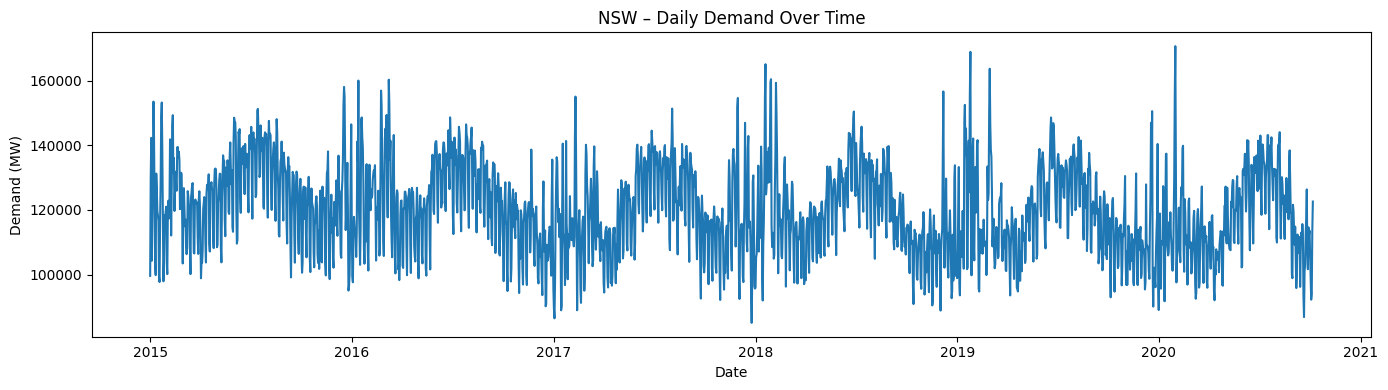

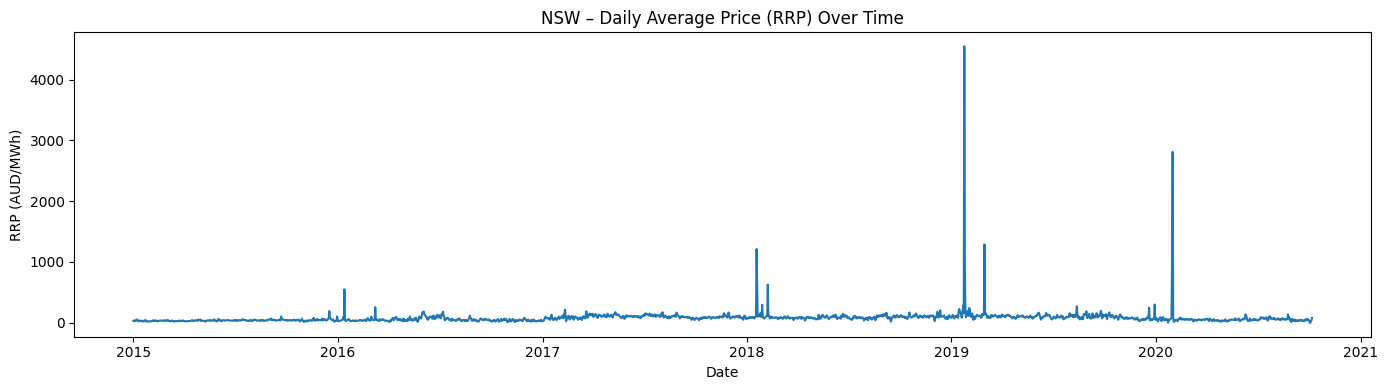

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))
plt.plot(df["date"], df["demand"])
plt.title("NSW – Daily Demand Over Time")
plt.ylabel("Demand (MW)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df["date"], df["RRP"])
plt.title("NSW – Daily Average Price (RRP) Over Time")
plt.ylabel("RRP (AUD/MWh)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


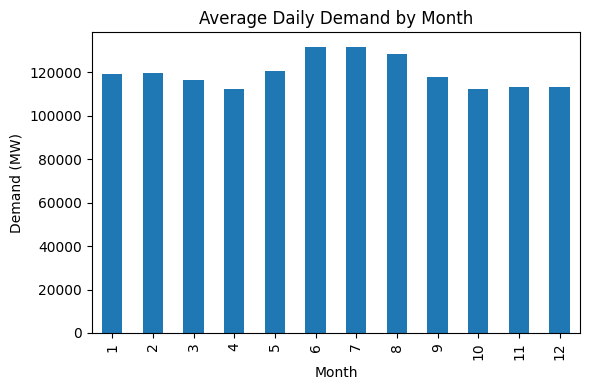

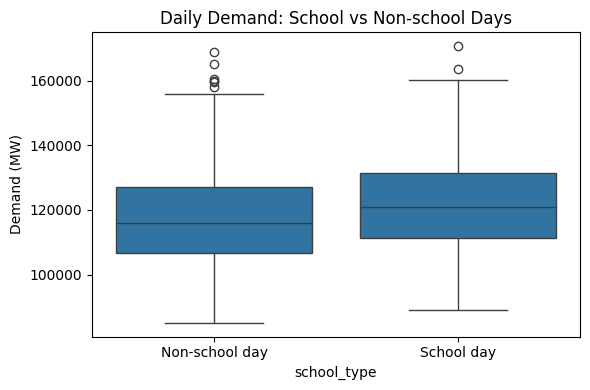

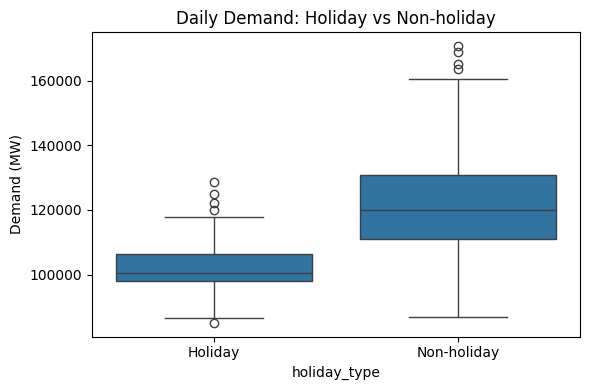

In [8]:
# Average demand by month
plt.figure(figsize=(6,4))
df.groupby("month")["demand"].mean().plot(kind="bar")
plt.title("Average Daily Demand by Month")
plt.xlabel("Month")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.show()

# School day vs non-school day
df["school_type"] = df["school_day_flag"].map({1: "School day", 0: "Non-school day"})
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="school_type", y="demand")
plt.title("Daily Demand: School vs Non-school Days")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.show()

# Holiday vs non-holiday
df["holiday_type"] = df["holiday_flag"].map({1: "Holiday", 0: "Non-holiday"})
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="holiday_type", y="demand")
plt.title("Daily Demand: Holiday vs Non-holiday")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.show()


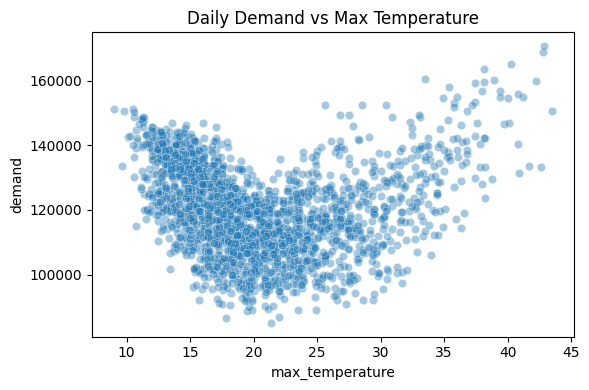

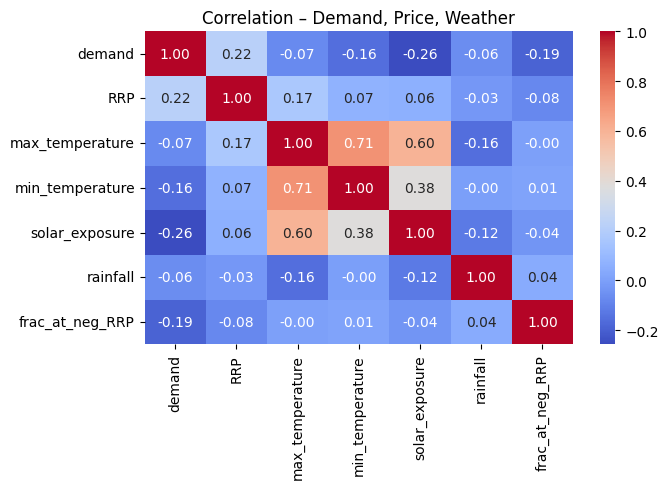

In [9]:
# Scatter: demand vs max temperature
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x="max_temperature", y="demand",
    alpha=0.4
)
plt.title("Daily Demand vs Max Temperature")
plt.tight_layout()
plt.show()

# Correlation heatmap
corr_cols = [
    "demand",
    "RRP",
    "max_temperature",
    "min_temperature",
    "solar_exposure",
    "rainfall",
    "frac_at_neg_RRP"
]
corr = df[corr_cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation – Demand, Price, Weather")
plt.tight_layout()
plt.show()


In [11]:
from scipy import stats

valid = df[["demand", "max_temperature"]].dropna()
r, p = stats.pearsonr(valid["max_temperature"], valid["demand"])

print(f"Pearson r = {r:.3f}, p-value = {p:.5f}")


Pearson r = -0.073, p-value = 0.00077


In [12]:
school = df.loc[df["school_day_flag"] == 1, "demand"].dropna()
nonschool = df.loc[df["school_day_flag"] == 0, "demand"].dropna()

t_stat, p_val = stats.ttest_ind(school, nonschool, equal_var=False)
print(f"t-stat = {t_stat:.3f}, p-value = {p_val:.5f}")


t-stat = 5.439, p-value = 0.00000


In [13]:
rainy = df.loc[df["rainfall"] > 0, "demand"].dropna()
dry   = df.loc[df["rainfall"] == 0, "demand"].dropna()

t_stat2, p_val2 = stats.ttest_ind(rainy, dry, equal_var=False)
print(f"t-stat = {t_stat2:.3f}, p-value = {p_val2:.5f}")


t-stat = 1.524, p-value = 0.12777


## Daily Demand–Weather–Calendar Report (NSW)

### 1. Data and Preprocessing

In this analysis, I used a consolidated daily dataset for New South Wales electricity demand with integrated weather and calendar features:

- **Source file:** `complete_dataset.csv`
- **Granularity:** One row per **date** (daily level)
- **Key variables:**
  - **Demand & Price**
    - `demand`: daily electricity demand (MW)
    - `RRP`: daily average regional reference price (AUD/MWh)
    - `demand_pos_RRP`, `demand_neg_RRP`, `frac_at_neg_RRP`: splits of demand by positive/negative price conditions
  - **Weather**
    - `min_temperature`, `max_temperature`
    - `solar_exposure`
    - `rainfall`
  - **Calendar / Behavioural**
    - `school_day`: whether the day is a school day
    - `holiday`: whether the day is a public holiday

**Preprocessing steps:**

- Parsed `date` as a datetime field.
- Derived time-based features: `year`, `month`, `dayofweek`, `is_weekend`.
- Normalized `school_day` and `holiday` into numeric flags: `school_day_flag`, `holiday_flag` (0/1).
- Dropped rows with invalid or unmappable label values for these flags.
- Retained all rows where `demand` and core weather variables were non-missing.

This produced a clean daily panel suitable for exploratory analysis, hypothesis testing, and subsequent machine learning.

---

### 2. Exploratory Data Analysis (EDA)

**Demand behaviour over time**

- The time series of `demand` shows:
  - [Describe seasonality – e.g., higher loads in summer/winter, any visible trend.]
  - [Note any structural breaks or unusual periods.]

**Seasonality and calendar effects**

- **By month:**
  - Average daily demand is highest in months: **[X, Y]**, and lowest in **[A, B]**.
  - This is consistent with **heating/cooling-driven** demand patterns.

- **School days vs non-school days:**
  - School days exhibit **[higher / lower / similar]** median demand compared to non-school days.
  - Boxplots indicate **[narrower / wider]** spread on [school/non-school] days.

- **Holidays vs non-holidays:**
  - On public holidays, demand tends to be **[higher/lower]** relative to normal working days, suggesting changes in occupancy and behaviour.

**Weather relationships**

- `max_temperature` and `demand` show a **[positive/negative/nonlinear]** association in the scatter plot.
- `rainfall` appears to have a **[weak/moderate]** relationship with demand.
- Correlation matrix highlights:
  - `demand` vs `max_temperature`: **r ≈ [value]**
  - `demand` vs `solar_exposure`: **r ≈ [value]**
  - `demand` vs `rainfall`: **r ≈ [value]**

These patterns confirm that both **weather** and **calendar structure** are relevant drivers of daily demand.

---

## 3. Hypothesis Testing Results

### 3.1. Correlation Between Max Temperature and Demand

**Hypotheses**

- **H₀:** There is no linear correlation between daily maximum temperature (`max_temperature`) and daily electricity demand (`demand`).
- **H₁:** There is a significant linear correlation between maximum temperature and demand.

**Method**

- Pearson correlation on all days with non-missing `demand` and `max_temperature`.

**Results**

- Pearson **r = -0.073**, **p-value ≈ 0.00077**

**Decision (α = 0.05)**

- Since *p < 0.05*, we **reject H₀**.
- Statistically, there is evidence of a relationship between temperature and demand.
- However, the effect size (**r = -0.073**) is **very small** (weak negative correlation).

**Interpretation**

- Higher maximum temperatures are associated with a **slight decrease** in daily demand, but the magnitude of the relationship is operationally small.
- The statistical significance is driven by the large sample size; from a business/operations lens, temperature alone does **not** explain a large fraction of demand variability.

---

### 3.2. School Days vs Non-School Days

**Hypotheses**

- **H₀:** Mean daily demand on school days equals mean daily demand on non-school days.
- **H₁:** Mean daily demand on school days differs from mean daily demand on non-school days.

**Method**

- Two-sample Welch t-test (`stats.ttest_ind` with `equal_var=False`) comparing:
  - `school_day_flag = 1` (school days)
  - `school_day_flag = 0` (non-school days)

**Results**

- **t-statistic = 5.439**, **p-value ≈ 0.00000** (effectively < 1e-5)

**Decision (α = 0.05)**

- Since *p ≪ 0.05*, we **strongly reject H₀**.
- There is a statistically significant difference in mean demand between school and non-school days.
- The positive t-statistic (with `school` as the first sample) indicates that **school days have higher average demand** than non-school days.

**Interpretation**

- School activity is a material driver of system load: when schools are operating, overall electricity demand is **systematically higher**.
- This effect should be explicitly modelled in any forecasting or scenario-planning workflows (e.g., via a `school_day_flag` feature).

---

### 3.3. Rainy vs Dry Days

**Hypotheses**

- **H₀:** Mean daily demand on rainy days equals mean daily demand on dry days.
- **H₁:** Mean daily demand on rainy days differs from mean daily demand on dry days.

**Method**

- Two-sample Welch t-test comparing:
  - `rainfall > 0`  → rainy days
  - `rainfall = 0`  → dry days

**Results**

- **t-statistic = 1.524**, **p-value ≈ 0.12777**

**Decision (α = 0.05)**

- Since *p > 0.05*, we **fail to reject H₀**.
- There is **no statistically significant difference** in mean demand between rainy and dry days at the 5% significance level.

**Interpretation**

- Within this dataset, rainfall alone does **not** generate a meaningful shift in aggregate daily demand.
- Any rainfall-related impacts are either small, highly localized, or overshadowed by stronger drivers such as temperature, school calendar, and broader seasonal effects.

---

### 3.4. Overall Takeaways

- **Temperature:** Statistically significant but **operationally weak** negative correlation with demand (r ≈ -0.07).
- **School calendar:** Strong, statistically robust effect; school days are **consistently higher-demand** days.
- **Rainfall:** No statistically significant impact on aggregate daily demand.

These findings justify:

- Using `school_day_flag` as a **key explanatory feature** in downstream regression/classification models.
- Keeping weather features (especially temperature) in the model, but not expecting them to capture a large share of variance on their own.
- De-prioritizing rainfall as a primary driver in first-pass forecasting models, unless we later move to more granular (e.g., regional or intraday) analyses.


